### Init


In [2]:
# Loading the libraries
from util import *
import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import random
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

import warnings
warnings.filterwarnings('ignore')

In [3]:
all_data = pd.read_csv(r'..\Preprocessed_datasets\preprocessed_wine.csv', index_col=0)
errors = all_data['errors']
features = all_data.drop(['predicted_class', 'true_class', 'errors'], axis=1)


In [4]:
# Scaling the features 
to_scale = features.columns
features[to_scale] = StandardScaler().fit_transform(features[to_scale])
features[:5]

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline
12,0.687846,-0.160373,0.141557,-0.694417,-0.834587,0.004312,0.267992,-0.318793,0.017405,0.697247,0.405843,-0.146241,1.256507
23,-0.356751,-0.343481,0.502356,-0.101678,-0.381526,-0.222556,-0.278564,-0.635733,-0.650337,-0.367414,-0.033392,1.394286,0.408775
25,-0.124619,0.290352,2.798346,2.269277,1.808272,0.061029,0.155878,1.582845,0.227267,-0.590546,0.259431,0.486852,-0.105424
35,0.374467,-0.047692,0.141557,0.787430,-0.003974,0.193369,0.576306,-0.635733,0.112797,0.378486,-0.399421,1.056636,0.144727
13,1.848509,-0.160373,0.075958,-2.209194,-0.683567,0.949596,1.571320,1.160258,1.925240,0.569743,1.137900,-0.504994,0.784001


### Utils

In [9]:
# TODO: experiment with different random states, increase number of runs
clus_model_kwargs = {
    "n_clusters": 2,
    "init": "k-means++",
    "n_init": 10,
    "max_iter": 300,
    "random_state": 2,
}


In [13]:
def plot_clusters(data):    
    scatterplot = sns.scatterplot(data=data, x="alcohol", y="ash", hue="clusters", size='errors', sizes=(100, 20), palette="tab10")
    plt.show()

In [15]:
def accuracy(results):
    correct = results.loc[results['errors'] == 0]
    # print('Correct:', len(correct), ' -  Total:', len(results))
    acc = len(correct)/len(results)
    # print('Accuracy:', acc)
    return acc

def bias_acc(data, cluster_id, cluster_col):
    cluster_x = data.loc[data[cluster_col] == cluster_id]
    remaining_clusters = data.loc[data[cluster_col] != cluster_id]
    return accuracy(remaining_clusters) - accuracy(cluster_x)

def get_next_cluster(data):
    n_cluster = max(data['clusters'])
    highest_variance = -1
    cluster_number = 0

    for i in range(0, n_cluster):
        cluster_i = data.loc[data['clusters'] == i]
        variance_cluster = np.var(cluster_i['errors'])
        
        if variance_cluster > highest_variance:
            highest_variance = variance_cluster
            cluster_number = i
            print('--> Cluster with the highest variance:', cluster_number)

    return cluster_number

### Clustering 

In [20]:
# Combine scaled features w. class & error labels
full_data = features.copy(deep=True)
full_data['true_class'] = all_data[['true_class']]
full_data['predicted_class'] = all_data[['predicted_class']]
full_data['errors'] = all_data[['errors']]
full_data['clusters'] = 0
full_data['new_clusters'] = -1
full_data.head()

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline,true_class,predicted_class,errors,clusters,new_clusters
12,0.687846,-0.160373,0.141557,-0.694417,-0.834587,0.004312,0.267992,-0.318793,0.017405,0.697247,0.405843,-0.146241,1.256507,0.0,0,0.0,0,-1
23,-0.356751,-0.343481,0.502356,-0.101678,-0.381526,-0.222556,-0.278564,-0.635733,-0.650337,-0.367414,-0.033392,1.394286,0.408775,0.0,1,1.0,0,-1
25,-0.124619,0.290352,2.798346,2.269277,1.808272,0.061029,0.155878,1.582845,0.227267,-0.590546,0.259431,0.486852,-0.105424,0.0,0,0.0,0,-1
35,0.374467,-0.047692,0.141557,0.787430,-0.003974,0.193369,0.576306,-0.635733,0.112797,0.378486,-0.399421,1.056636,0.144727,0.0,1,1.0,0,-1
13,1.848509,-0.160373,0.075958,-2.209194,-0.683567,0.949596,1.571320,1.160258,1.925240,0.569743,1.137900,-0.504994,0.784001,0.0,2,1.0,0,-1


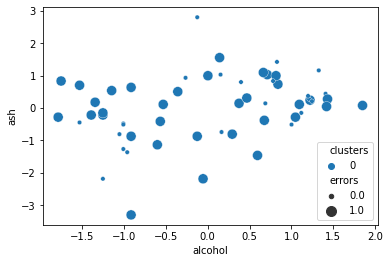

----- Clustering Iteration 1
Splitting on cluster 0


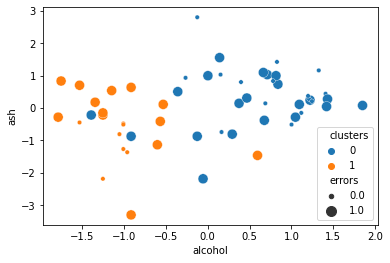

--> Cluster with the highest variance: 0
----- Clustering Iteration 2
Splitting on cluster 0


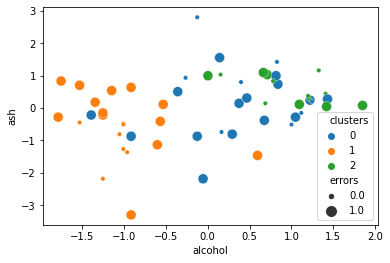

--> Cluster with the highest variance: 0
--> Cluster with the highest variance: 1
----- Clustering Iteration 3
Splitting on cluster 1


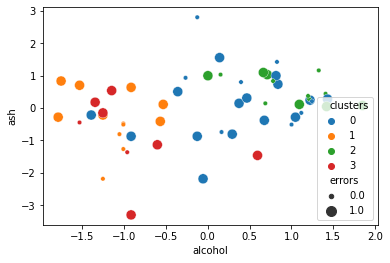

--> Cluster with the highest variance: 0
--> Cluster with the highest variance: 1
--> Cluster with the highest variance: 2
----- Clustering Iteration 4
Splitting on cluster 2


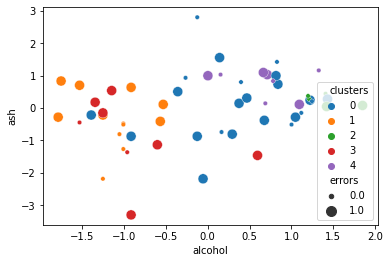

--> Cluster with the highest variance: 0
--> Cluster with the highest variance: 1
----- Clustering Iteration 5
Splitting on cluster 1


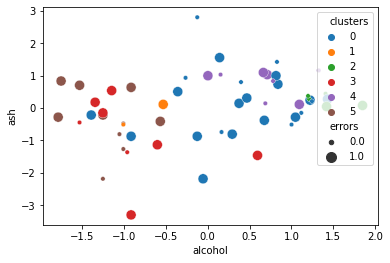

--> Cluster with the highest variance: 0
--> Cluster with the highest variance: 1
----- Clustering Iteration 6
Splitting on cluster 1
The selected cluster is not splitted. Picking a random cluster...
----- Clustering Iteration 7
Splitting on cluster 3


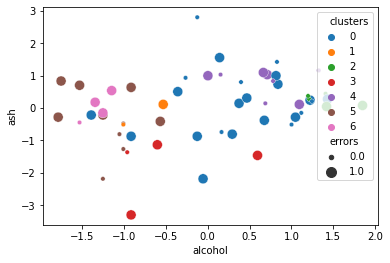

--> Cluster with the highest variance: 0
--> Cluster with the highest variance: 1
----- Clustering Iteration 8
Splitting on cluster 1
The selected cluster is not splitted. Picking a random cluster...
----- Clustering Iteration 9
Splitting on cluster 5


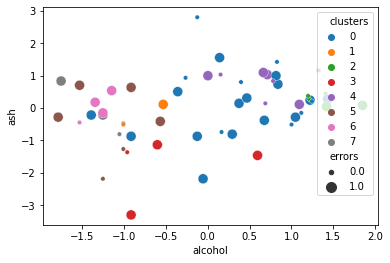

--> Cluster with the highest variance: 0
--> Cluster with the highest variance: 1
----- Clustering Iteration 10
Splitting on cluster 1
The selected cluster is not splitted. Picking a random cluster...
----- Clustering Iteration 11
Splitting on cluster 3
The selected cluster is not splitted. Picking a random cluster...
----- Clustering Iteration 12
Splitting on cluster 2
The selected cluster is not splitted. Picking a random cluster...
----- Clustering Iteration 13
Splitting on cluster 1
The selected cluster is not splitted. Picking a random cluster...
----- Clustering Iteration 14
Splitting on cluster 4


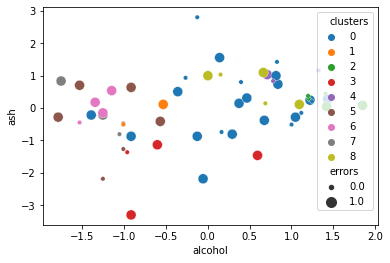

--> Cluster with the highest variance: 0
--> Cluster with the highest variance: 1
----- Clustering Iteration 15
Splitting on cluster 1
The selected cluster is not splitted. Picking a random cluster...
----- Clustering Iteration 16
Splitting on cluster 2
The selected cluster is not splitted. Picking a random cluster...
----- Clustering Iteration 17
Splitting on cluster 0


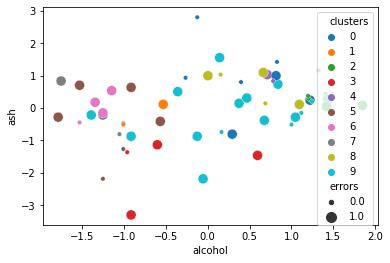

--> Cluster with the highest variance: 0
--> Cluster with the highest variance: 1
----- Clustering Iteration 18
Splitting on cluster 1
The selected cluster is not splitted. Picking a random cluster...
----- Clustering Iteration 19
Splitting on cluster 9


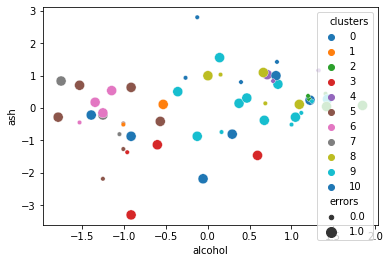

--> Cluster with the highest variance: 0
--> Cluster with the highest variance: 1
MAX_ITER


In [21]:
MAX_ITER = 20
x = 0 # cluster number
initial_bias = 0
plot_clusters(full_data)

for i in range(1, MAX_ITER):
    print('----- Clustering Iteration', i)
    print('Splitting on cluster', x)

    full_data['new_clusters'] = -1
    candidate_cluster = full_data.loc[full_data['clusters'] == x] 
    #print(candidate_cluster.head())

    if len(candidate_cluster) < 8:
        print('The selected cluster is not splitted. Picking a random cluster...')
        n_cluster = max(full_data['clusters'])
        x = random.randint(0, n_cluster)
        initial_bias = abs(bias_acc(full_data, x, 'clusters'))
        continue
    
    # Apply Kmeans 
    kmeans_algo = KMeans(**clus_model_kwargs).fit(candidate_cluster.drop(['clusters', 'new_clusters', 'predicted_class', 'true_class', 'errors'], axis=1))
    
    candidate_cluster['new_clusters'] = pd.DataFrame(kmeans_algo.predict(candidate_cluster.drop(['clusters', 'new_clusters', 'predicted_class', 'true_class', 'errors'], axis=1)),index=candidate_cluster.index) 
    # print(candidate_cluster.head())

    full_data['new_clusters'] = candidate_cluster['new_clusters'].combine_first(full_data['new_clusters'])
    # print(full_data.head())
        
    # calculate bias & cluster size for each of the two clusters
    negative_bias_0 = bias_acc(full_data, 0, 'new_clusters')
    negative_bias_1 = bias_acc(full_data, 1, 'new_clusters') 
    max_abs_bias = max(abs(negative_bias_0), abs(negative_bias_1))
    min_new_size = min( len(full_data.loc[full_data['new_clusters']==0]), len(full_data.loc[full_data['new_clusters']==1]) )
    
    if (max_abs_bias >= initial_bias) & (min_new_size > 1): 
        # Add new cluster
        n_cluster = max(full_data['clusters'])
        full_data['clusters'][full_data['new_clusters'] == 1] =  n_cluster + 1
        #print(full_data.head())
        
        plot_clusters(full_data)

        x = get_next_cluster(full_data)
        initial_bias = abs(bias_acc(full_data, x, 'clusters'))
    else:
        print('Initial bias:', initial_bias, '  -  Max abs. candidate bias:', max_abs_bias)
        print('Min candidate size:', min_new_size)
        print('The selected cluster is not splitted. Picking a random cluster...')
        n_cluster = max(full_data['clusters'])
        x = random.randint(0, n_cluster)
        initial_bias = abs(bias_acc(full_data, x, 'clusters'))
        
print('MAX_ITER')

In [29]:
# exporting the biased cluster dataframe for further analysis
import os
path = r'..\\Clustered_datasets\\'
full_data.to_csv(os.path.join(path, r'biased_wine_clusters.csv'))
